### Links to Reference

[Keras Multi Output Model](https://github.com/rodrigobressan/keras-multi-output-model-utk-face/blob/master/notebook.ipynb)

[Keras Documentation - Functional API](https://keras.io/guides/functional_api/)

[Stack Overflow - How to Implement Multilabel Classification with UTKFace](https://stackoverflow.com/questions/66852823/how-to-implement-multilabel-classification-on-utkface-dataset-using-tensorflow-a)

[Tensorflow Guide - Keras Train and Evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)

[Stack Overflow - Keras Value Error with Dimensions](https://stackoverflow.com/questions/61069068/keras-valueerror-dimensions-must-be-equal-but-are-6-and-9-for-node-equal)

[Helpful Guide for Age + Gender Detection Using DL](https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/)

[Keras Model Output Always Same Error](https://github.com/keras-team/keras/issues/6447)

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import cv2

### Image Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

**age** is an integer from 0 to 116, indicating the age

**gender** is either 0 (male) or 1 (female)

**race** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

**date&time** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [2]:
dataset_dict = {
    'race_id': {
        0: 'White', 
        1: 'Black', 
        2: 'Asian', 
        3: 'Indian', 
        4: 'Others'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

dataset_dict

{'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'},
 'gender_id': {0: 'Male', 1: 'Female'},
 'gender_alias': {'Male': 0, 'Female': 1},
 'race_alias': {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}}

### Loading Data into Text and CSV Files

In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [4]:
def parse_dataset_raw(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_raw_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), int(gender), int(race)
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_raw_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [5]:
dataset_path = "UTKFace"
df = parse_dataset(dataset_path)
df

,Age,Gender,Race,File
0,9.0,Female,Asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,Male,Black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,Female,White,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,Female,White,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,Female,Asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,Male,White,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,Male,Indian,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,Male,Black,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,Male,Black,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [6]:
df_raw = parse_dataset_raw(dataset_path)
df_raw

,Age,Gender,Race,File
0,9.0,1.0,2.0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,0.0,1.0,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,1.0,0.0,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,1.0,0.0,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,1.0,2.0,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,0.0,0.0,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,0.0,3.0,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,0.0,1.0,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,0.0,1.0,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [7]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img = fig.to_image(format="png")
    display(Image(img))

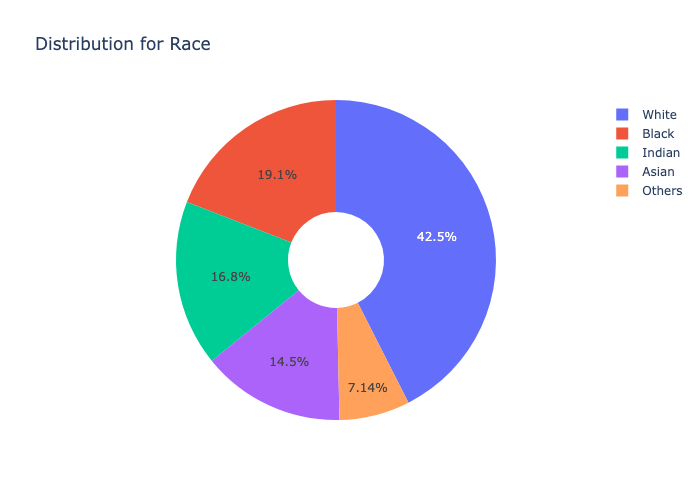

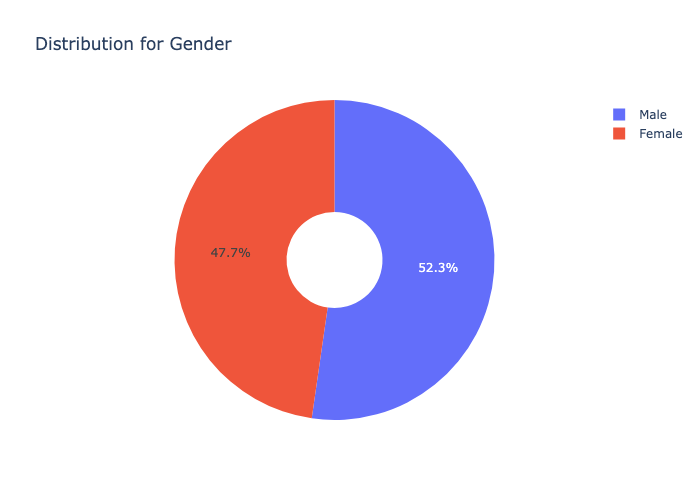

In [8]:
plot_distribution(df["Race"])
plot_distribution(df["Gender"])

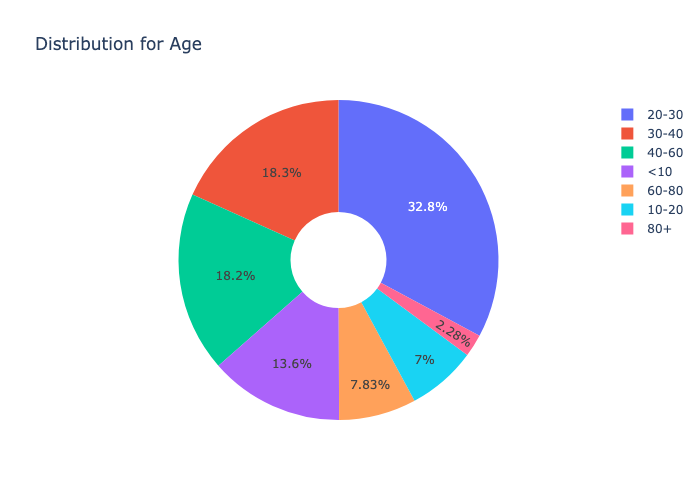

In [9]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['Age'], bins, labels=names)
plot_distribution(age_binned)


In [10]:
ages = df_raw["Age"].tolist()
genders = df_raw["Gender"].tolist()
print(len(ages))
print(len(genders))

23705
23705


In [11]:
files = df_raw["File"].tolist()
print(len(files))

images = []
for file in files: 
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(48,48))
    
    images.append(image)

print(len(images))

23705
23705


In [12]:
labels = []

i = 0
while i < len(ages): 
    label = []
    label.append(([ages[i]]))
    label.append(([genders[i]]))
    labels.append(label)
    i += 1

print(len(labels))
print(labels[0])

23705
[[9.0], [1.0]]


In [13]:
print(type(ages))
print(type(genders))
print(type(images))
print(type(labels))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [14]:
ages_f = np.array(ages)
genders_f = np.array(genders)
labels_f = np.array(labels)
images_f = np.array(images)
images_f_2 = images_f / 255
print(ages_f.shape)
print(genders_f.shape)
print(labels_f.shape)
print(images_f.shape)

(23705,)
(23705,)
(23705, 2, 1)
(23705, 48, 48, 3)


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(images_f, labels_f, test_size=0.25)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17778, 48, 48, 3)
(5927, 48, 48, 3)
(17778, 2, 1)
(5927, 2, 1)


In [17]:
y_train_2 = [y_train[:,1],y_train[:,0]]
y_test_2 = [y_test[:,1],y_test[:,0]]

In [18]:
y_train_2[0][0:5]

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [19]:
y_train_2[1][0:5]

array([[67.],
       [26.],
       [30.],
       [70.],
       [44.]])

In [20]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [21]:
def Convolution(input_tensor,filters):
    x = Conv2D(filters=32,kernel_size=(3, 3),padding = 'same',kernel_regularizer=l2(0.01))(input_tensor)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)

    return x

def model(input_shape):
    inputs = Input((input_shape))

    conv_1= Convolution(inputs,64)
    maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
    conv_2 = Convolution(maxp_1,32)
    maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
    conv_3 = Convolution(maxp_2,64)
    maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
    conv_4 = Convolution(maxp_3,512)
    maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
    flatten= Flatten() (maxp_4)
    dense_1= Dense(64,activation='relu')(flatten)
    dense_2= Dense(64,activation='relu')(flatten)
    drop_1=Dropout(0.2)(dense_1)
    drop_2=Dropout(0.2)(dense_2)
    output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
    output_2= Dense(1,activation="relu",name='age_out')(drop_2)
    model = Model(inputs=[inputs], outputs=[output_1,output_2])
    model.compile(loss=["binary_crossentropy","mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

    return model

In [22]:
test_model = model((48, 48, 3))
test_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-30 18:49:16.696559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 18:49:16.696780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   896         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['dropout[0][0]']                
                                                                                              

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
fle_s='model_prediction.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [25]:
History = test_model.fit(x_train,y_train_2,batch_size=32,validation_data=(x_test,y_test_2),epochs=50,callbacks=[callback_list])


Epoch 1/50


2022-05-30 18:49:17.474955: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-30 18:49:17.991180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


556/556 [==============================] - ETA: 0s - loss: 19.6250 - sex_out_loss: 2.0595 - age_out_loss: 16.5736 - sex_out_accuracy: 0.5804 - age_out_accuracy: 0.0469

2022-05-30 18:49:33.941955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 23.81566, saving model to model_prediction.h5
556/556 [==============================] - 18s 25ms/step - loss: 19.6250 - sex_out_loss: 2.0595 - age_out_loss: 16.5736 - sex_out_accuracy: 0.5804 - age_out_accuracy: 0.0469 - val_loss: 23.8157 - val_sex_out_loss: 0.6708 - val_age_out_loss: 22.1813 - val_sex_out_accuracy: 0.6416 - val_age_out_accuracy: 0.0472
Epoch 2/50
555/556 [============================>.] - ETA: 0s - loss: 16.6696 - sex_out_loss: 0.8630 - age_out_loss: 14.8669 - sex_out_accuracy: 0.6026 - age_out_accuracy: 0.0474
Epoch 2: val_loss did not improve from 23.81566
556/556 [==============================] - 13s 23ms/step - loss: 16.6689 - sex_out_loss: 0.8631 - age_out_loss: 14.8661 - sex_out_accuracy: 0.6027 - age_out_accuracy: 0.0474 - val_loss: 25.5750 - val_sex_out_loss: 0.6564 - val_age_out_loss: 24.0010 - val_sex_out_accuracy: 0.6313 - val_age_out_accuracy: 0.0472
Epoch 3/50
554/556 [============================>.] - ETA: 0s - l

In [26]:
test_model.evaluate(x_test, y_test_2)

186/186 [==============================] - 1s 7ms/step - loss: 18.2714 - sex_out_loss: 0.3887 - age_out_loss: 17.2806 - sex_out_accuracy: 0.8414 - age_out_accuracy: 0.0079


[18.27136993408203,
 0.3886544406414032,
 17.280563354492188,
 0.8414037227630615,
 0.00792981218546629]

In [27]:
pred = test_model.predict(x_test)
pred[1]

2022-05-30 18:59:55.790264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[15.327335],
       [13.595268],
       [ 9.240599],
       ...,
       [36.118874],
       [42.136772],
       [10.385439]], dtype=float32)

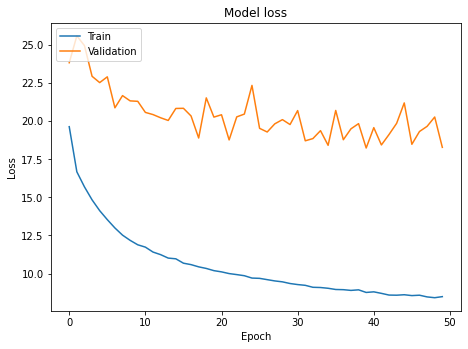

In [28]:
import matplotlib.pyplot as plt 

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

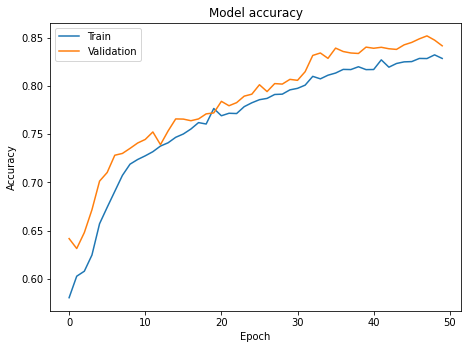

In [34]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

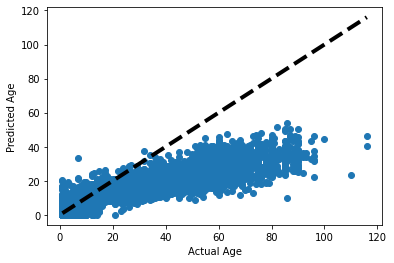

In [35]:
fig, ax = plt.subplots()
ax.scatter(y_test_2[1], pred[1])
ax.plot([y_test_2[1].min(),y_test_2[1].max()], [y_test_2[1].min(), y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [29]:
def test_image(idx, images_f, images_f_2, Model):
    plt.imshow(images_f[idx])
    image_test = images_f_2[idx]
    pred_1=Model.predict(np.array([image_test]))
    sex_f=['Male','Female']
    age = int(np.round(pred_1[1][0]))
    sex = int(np.round(pred_1[0][0]))
    print("Predicted Age: " + str(age))
    print("Predicted Sex: " + sex_f[sex])

2022-05-30 18:59:57.143563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predicted Age: 3
Predicted Sex: Male
34.0
0.0


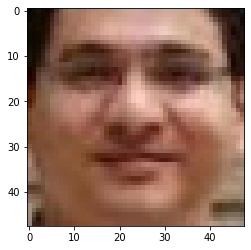

In [30]:
import random 

idx = random.randint(0, len(files))

test_image(idx, images_f, images_f_2, test_model)
print(ages[idx])
print(genders[idx])

Predicted Age: 3
Predicted Sex: Male


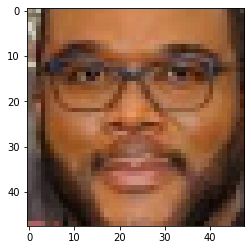

In [31]:
test_image(57,images_f,images_f_2,test_model)

Predicted Age: 3
Predicted Sex: Male


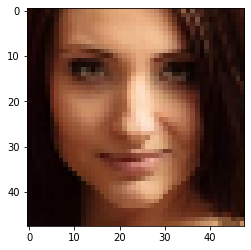

In [32]:
test_image(120,images_f,images_f_2,test_model)

Predicted Age: 3
Predicted Sex: Male


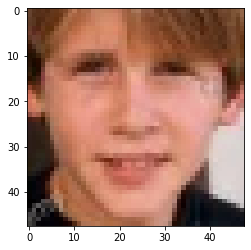

In [33]:
test_image(1500,images_f,images_f_2,test_model)